All this pre-process and processing steps come from the tutorial that can be found at https://scanpy-tutorials.readthedocs.io/en/latest/spatial/basic-analysis.html

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import scanpy as sc
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import leidenalg

In [2]:
# Load the dataset
# If the file exists read it; otherwise download and preprocess the dataset

if os.path.exists("V1_Human_Lymph_Node.h5ad"):
    adata = sc.read_h5ad("V1_Human_Lymph_Node.h5ad")
else:
    adata = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
    adata.var_names_make_unique()
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
    adata.write("V1_Human_Lymph_Node.h5ad")

In [3]:
# Controlling size of the dataset
adata.shape  # expected result: (4035, 36601)

(4035, 36601)

In [4]:
adata.obs.head()

in_tissue  array_row  array_col  n_genes_by_counts  \
AAACAAGTATCTCCCA-1          1         50        102               6732   
AAACAATCTACTAGCA-1          1          3         43               6759   
AAACACCAATAACTGC-1          1         59         19               8590   
AAACAGAGCGACTCCT-1          1         14         94               7236   
AAACAGCTTTCAGAAG-1          1         43          9               6890   

                    log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
AAACAAGTATCTCCCA-1                 8.814776       27944.0           10.237993   
AAACAATCTACTAGCA-1                 8.818778       25685.0           10.153702   
AAACACCAATAACTGC-1                 9.058470       42942.0           10.667629   
AAACAGAGCGACTCCT-1                 8.886962       31916.0           10.370894   
AAACAGCTTTCAGAAG-1                 8.837971       30932.0           10.339579   

                    pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
AAACAAGTATCTCCCA-1                   33.241483                    41.071429   
AAACAATCTACTAGCA-1                   23.507884                    33.965349   
AAACACCAATAACTGC-1                   22.502445                    31.770761   
AAACAGAGCGACTCCT-1                   21.948239                    31.990224   
AAACAGCTTTCAGAAG-1                   26.357817                    38.132032   

                    pct_counts_in_top_200_genes  pct_counts_in_top_500_genes  \
AAACAAGTATCTCCCA-1                    48.375322                    57.572287   
AAACAATCTACTAGCA-1                    42.631886                    53.054312   
AAACACCAATAACTGC-1                    40.584975                    50.815053   
AAACAGAGCGACTCCT-1                    41.101642                    52.603710   
AAACAGCTTTCAGAAG-1                    47.575327                    57.590844   

                    total_counts_mt  log1p_total_counts_mt  pct_counts_mt  
AAACAAGTATCTCCCA-1            248.0               5.517453       0.887489  
AAACAATCTACTAGCA-1            239.0               5.480639       0.930504  
AAACACCAATAACTGC-1            473.0               6.161207       1.101486  
AAACAGAGCGACTCCT-1            348.0               5.855072       1.090362  
AAACAGCTTTCAGAAG-1            793.0               6.677083       2.563688

In [5]:
adata.var.head()

gene_ids    feature_types  genome     mt  \
MIR1302-2HG  ENSG00000243485  Gene Expression  GRCh38  False   
FAM138A      ENSG00000237613  Gene Expression  GRCh38  False   
OR4F5        ENSG00000186092  Gene Expression  GRCh38  False   
AL627309.1   ENSG00000238009  Gene Expression  GRCh38  False   
AL627309.3   ENSG00000239945  Gene Expression  GRCh38  False   

             n_cells_by_counts  mean_counts  log1p_mean_counts  \
MIR1302-2HG                  0     0.000000           0.000000   
FAM138A                      0     0.000000           0.000000   
OR4F5                        0     0.000000           0.000000   
AL627309.1                  63     0.015861           0.015737   
AL627309.3                   0     0.000000           0.000000   

             pct_dropout_by_counts  total_counts  log1p_total_counts  
MIR1302-2HG             100.000000           0.0            0.000000  
FAM138A                 100.000000           0.0            0.000000  
OR4F5                   100.000000           0.0            0.000000  
AL627309.1               98.438662          64.0            4.174387  
AL627309.3              100.000000           0.0            0.000000

In [6]:
adata.X 

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 23717106 stored elements and shape (4035, 36601)>

<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

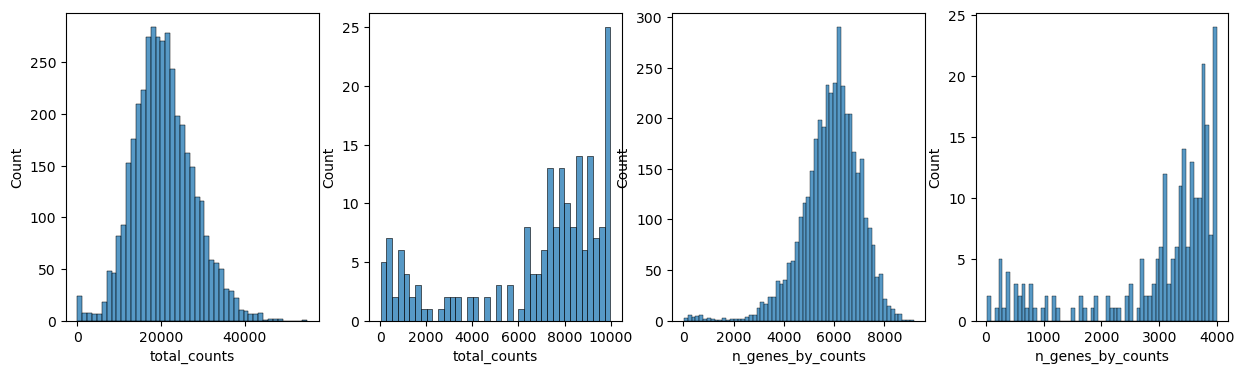

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(
    adata.obs["total_counts"][adata.obs["total_counts"] < 10000],
    kde=False,
    bins=40,
    ax=axs[1],
)
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.histplot(
    adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
    kde=False,
    bins=60,
    ax=axs[3],
)

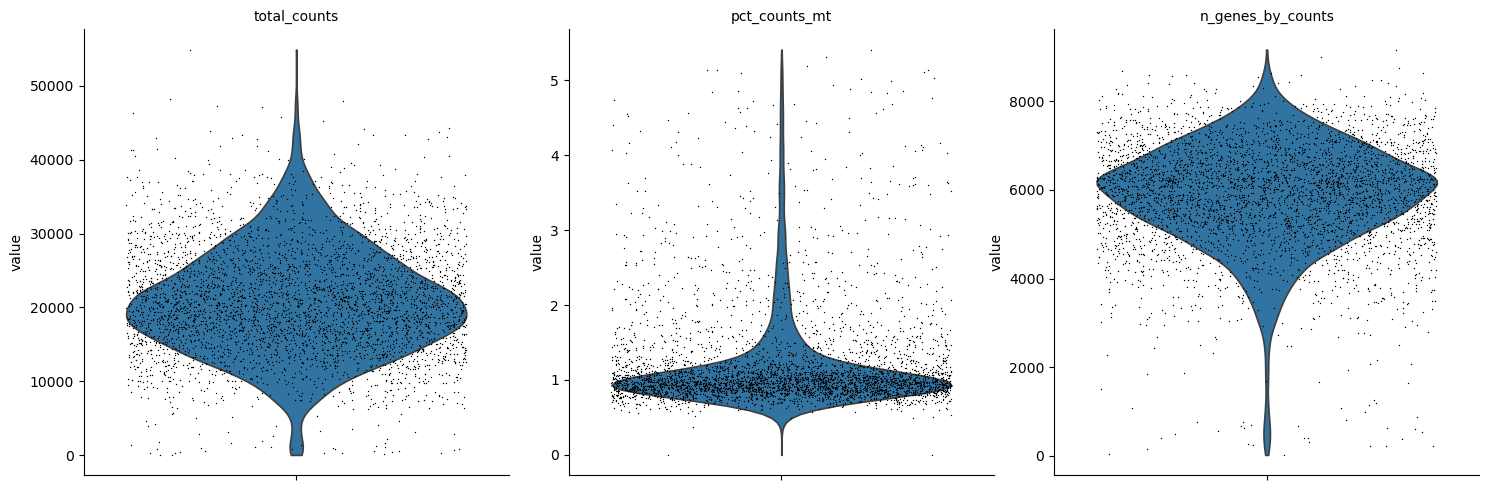

In [8]:
sc.pl.violin(adata, ['total_counts', 'pct_counts_mt', 'n_genes_by_counts'], jitter=0.4, multi_panel=True)


In [9]:
# Before filtering
n_cells_start = adata.n_obs
n_genes_start = adata.n_vars

# Filter cells with min counts
sc.pp.filter_cells(adata, min_counts=4000)
n_filtered_min = n_cells_start - adata.n_obs
print(f"filtered out {n_filtered_min} cells that have less than 4000 counts")

# Filter cells with max counts
n_cells_min = adata.n_obs
sc.pp.filter_cells(adata, max_counts=38000)
n_filtered_max = n_cells_min - adata.n_obs
print(f"filtered out {n_filtered_max} cells that have more than 38000 counts")

# Mitochondrial filter
n_cells_max = adata.n_obs
adata = adata[adata.obs["pct_counts_mt"] < 20].copy()
n_filtered_mt = n_cells_max - adata.n_obs
print(f"filtered out {n_filtered_mt} cells with pct_counts_mt ≥ 20%")
print(f"#cells after MT filter: {adata.n_obs}")

# Filter genes
n_genes_before = adata.n_vars
sc.pp.filter_genes(adata, min_cells=10)
n_genes_filtered = n_genes_before - adata.n_vars
print(f"filtered out {n_genes_filtered} genes that are detected in less than 10 cells")


filtered out 40 cells that have less than 4000 counts
filtered out 56 cells that have more than 38000 counts
filtered out 0 cells with pct_counts_mt ≥ 20%
#cells after MT filter: 3939
filtered out 16849 genes that are detected in less than 10 cells


In [10]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

In [11]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(
    adata, key_added="clusters", directed=False, n_iterations=2
)

/home/loren/miniconda3/envs/vae_scRNA/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/loren/miniconda3/envs/vae_scRNA/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


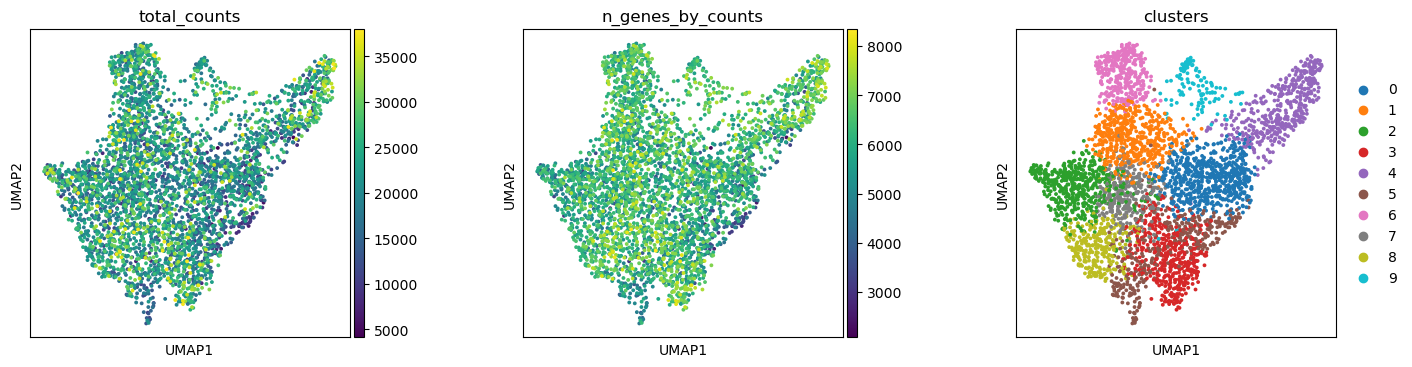

In [12]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

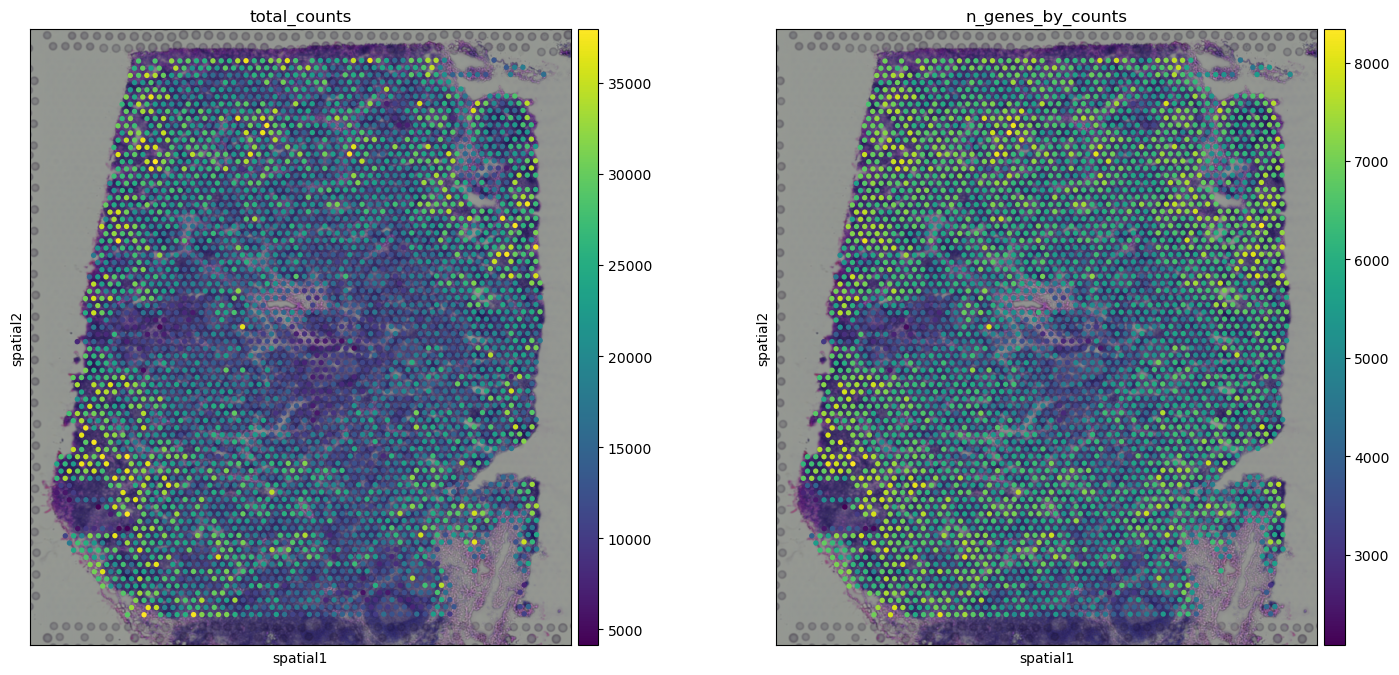

In [13]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])

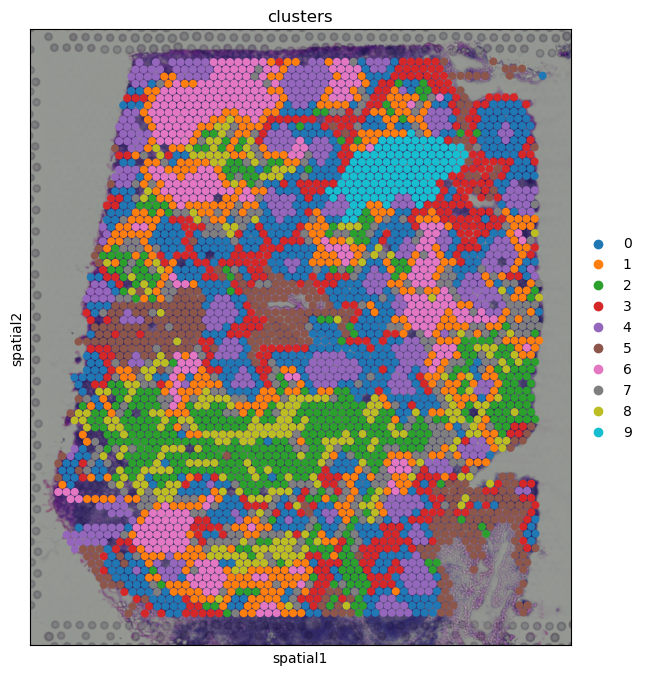

In [14]:
sc.pl.spatial(adata, img_key="hires", color="clusters", size=1.5)

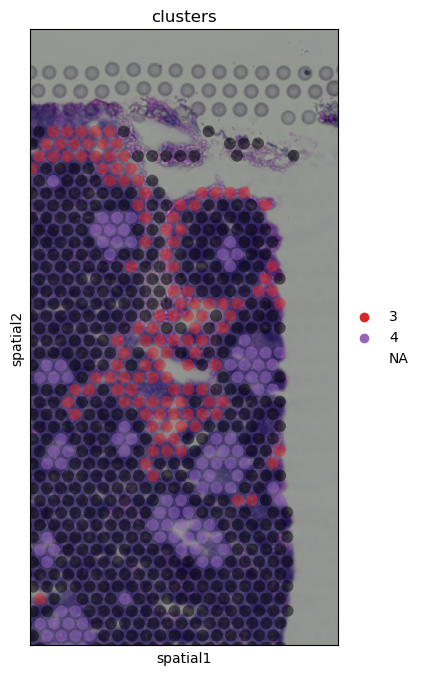

In [15]:
sc.pl.spatial(
    adata,
    img_key="hires",
    color="clusters",
    groups=["4", "3"],
    crop_coord=[7000, 10000, 0, 6000],
    alpha=0.5,
    size=1.3,
)

categories: 0, 1, 2, etc.
var_group_labels: 9


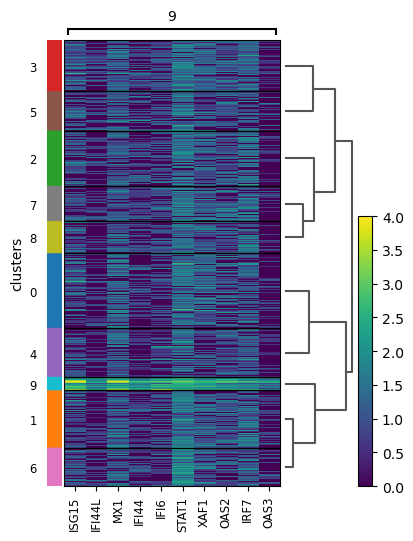

In [16]:
sc.tl.rank_genes_groups(adata, "clusters", method="t-test")
sc.pl.rank_genes_groups_heatmap(adata, groups="9", n_genes=10, groupby="clusters")

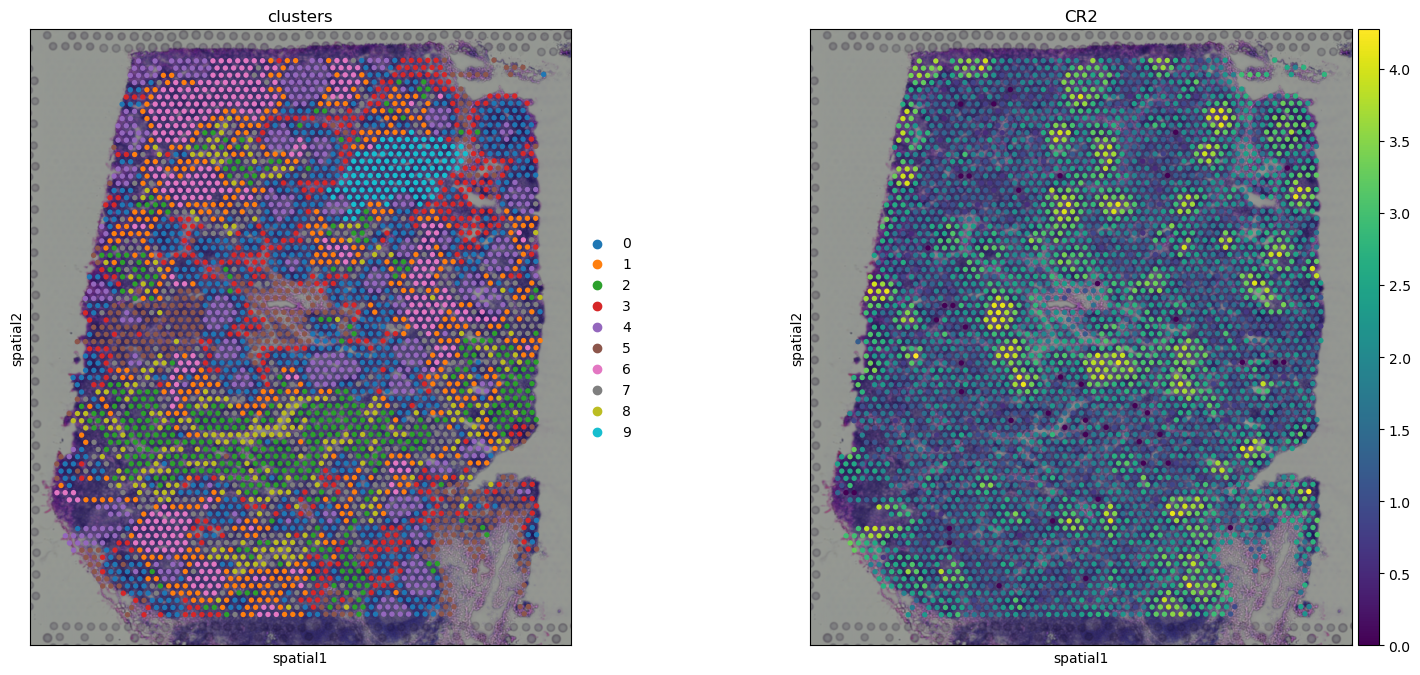

In [17]:
sc.pl.spatial(adata, img_key="hires", color=["clusters", "CR2"])

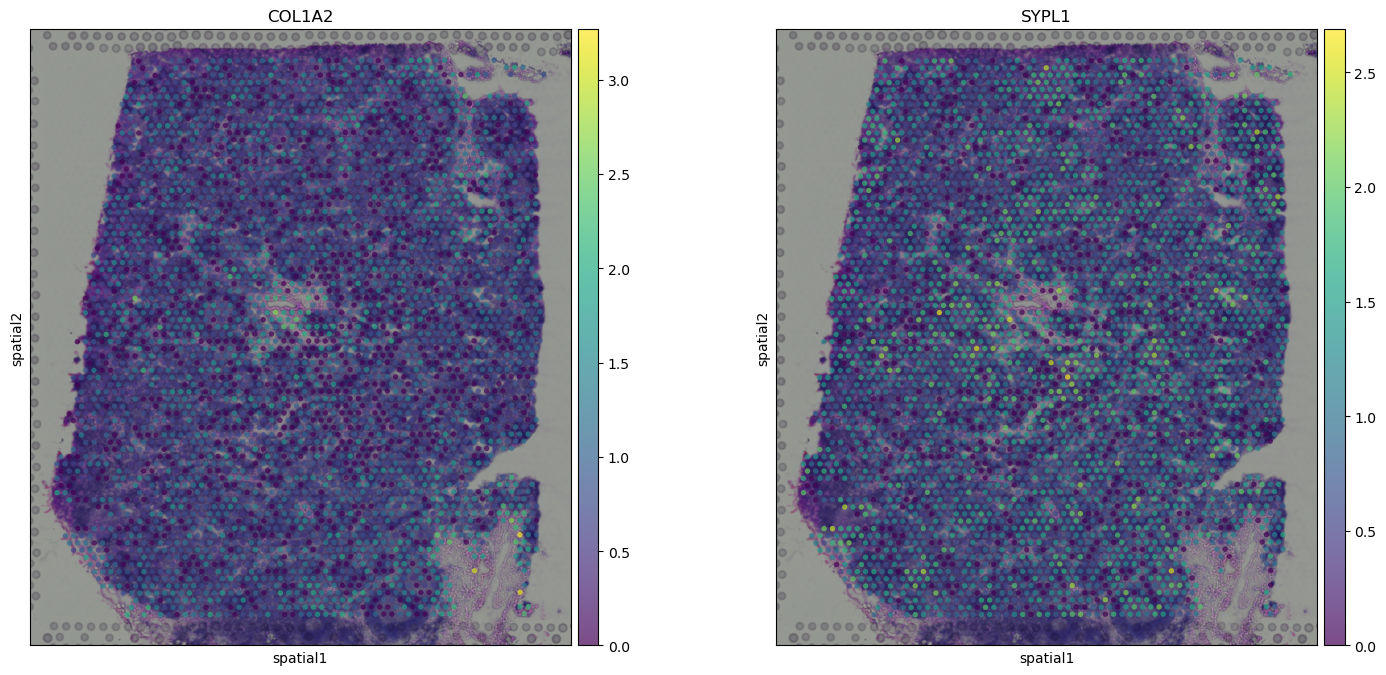

In [18]:
sc.pl.spatial(adata, img_key="hires", color=["COL1A2", "SYPL1"], alpha=0.7)